In [88]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn import svm, metrics
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import datetime
import progressbar
from time import sleep
import scipy.signal as signal 
from collections import Counter
sns.set(style="darkgrid")
from Build_LSTM import *

In [89]:

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}

In [90]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=60)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [92]:
df = pd.read_csv("../../../../datadrive/data_PD/preprocessed_data.csv", index_col=0)
df.dropna(axis=0, how='any', inplace=True)

In [94]:
df.head()

,AccX_aoa,AccX_apf,AccX_ate,AccX_minmax,AccX_rms,AccX_std,AccY_aoa,AccY_apf,AccY_ate,AccY_minmax,...,GyroY_minmax,GyroY_rms,GyroY_std,GyroZ_aoa,GyroZ_apf,GyroZ_ate,GyroZ_minmax,GyroZ_rms,GyroZ_std,label
not_walking5824,-0.9980,0.0331,36.6667,0.0046,0.9980,0.0008,-0.0063,0.0331,30.0000,0.0037,...,0.1829,1.4952,0.0385,-0.7441,0.0413,26.0000,0.1829,0.7454,0.0451,0.0
not_walking4786,-0.0666,0.0403,27.7500,0.0701,0.0680,0.0134,-0.5317,0.0323,30.0000,0.0635,...,18.7805,4.3085,4.1354,-1.6719,0.0242,46.0000,22.2256,5.0862,4.8035,0.0
not_walking6716,-0.9981,0.0450,24.0000,0.0061,0.9981,0.0016,-0.0057,0.0360,28.3333,0.0039,...,0.2134,1.5331,0.0471,-0.7248,0.0450,25.2500,0.1829,0.7261,0.0427,0.0
not_walking38357,0.4415,0.0397,26.2500,0.0056,0.4415,0.0011,-0.4092,0.0317,35.6667,0.0151,...,0.4573,1.6463,0.0881,-0.6891,0.0159,33.0000,0.6707,0.7081,0.1631,0.0
not_walking24689,-0.6263,0.0400,29.0000,0.0339,0.6263,0.0060,0.4385,0.0320,33.6667,0.0264,...,4.6342,1.8556,1.0717,-0.6185,0.0320,30.3333,2.8049,0.8053,0.5156,0.0


Text(0,0.5,u'Label')

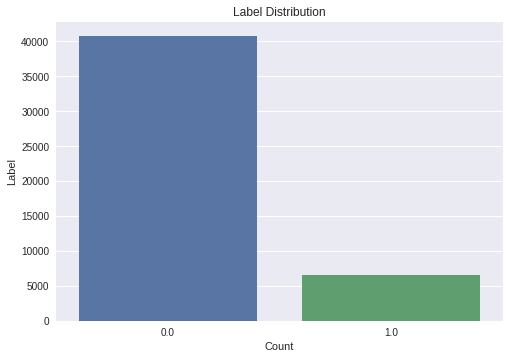

In [96]:
sns.countplot(x="label",data=df)
plt.title("Label Distribution")
plt.xlabel("Count")
plt.ylabel("Label")

In [100]:
df.shape

(47347, 43)

In [97]:
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.model_selection import KFold

In [98]:
X = df[df.columns[:-1]].values
y = df[df.columns[-1]].values

In [99]:
y_test_all = []
y_pred_all = []
kf = KFold(n_splits=10, shuffle=True)
for train, test in kf.split(X):
    
    X_training = X[train]
    X_test = X[test]
    y_training = y[train]
    y_test = y[test]
    class_weight = get_class_weights(y_training)
    
    model = LogisticRegression(penalty='l2', class_weight=class_weight)
    model.fit(X_training, y_training)
    y_pred = model.predict(X_test)
    
    y_test_all.extend(list(y_test))
    y_pred_all.extend(list(y_pred))
    

Confusion matrix, without normalization
[[25798 14957]
 [ 2077  4515]]
Normalized confusion matrix
[[0.63300209 0.36699791]
 [0.31507888 0.68492112]]


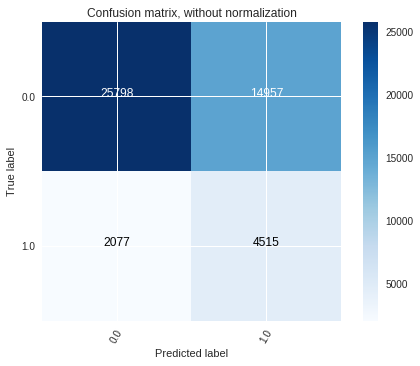

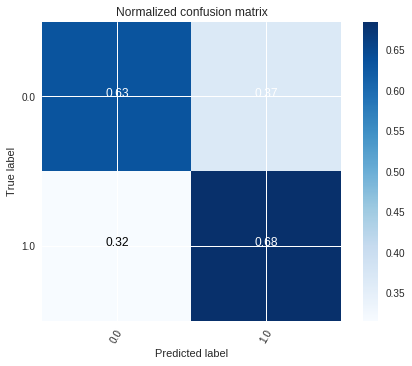

In [101]:
cnf_matrix = confusion_matrix(y_test_all, y_pred_all)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=model.classes_,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=model.classes_, normalize=True,
                      title='Normalized confusion matrix')
# plt.savefig(save_with_name+'.png')
plt.show()

In [102]:
from sklearn.metrics import classification_report
print(classification_report(y_test_all, y_pred_all))

             precision    recall  f1-score   support

        0.0       0.93      0.63      0.75     40755
        1.0       0.23      0.68      0.35      6592

avg / total       0.83      0.64      0.70     47347

